# EKF-SLAM

> This Tutorial is fetched from [this](https://github.com/Attila94/EKF-SLAM)

Basic algorithm creates robot object, generates (semi) random trajectory and estimates trajectory based on range-bearing measurements. Advanced algorithm is able to generate moving landmarks, but landmark classification has not been implemented.

In [15]:
#| hide
import numpy as np
from nours_notebooks.EKFSLAM.robot import Robot
from nours_notebooks.EKFSLAM.plotmap import plotMap, plotEstimate, plotMeasurement, plotError
from nours_notebooks.EKFSLAM.ekf import predict, update

# Generate static landmarks

In [25]:
n = 50 # number of static landmarks
mapsize = 40
landmark_xy = mapsize*(np.random.rand(n,2)-0.5)
landmark_id = np.transpose([np.linspace(0,n-1,n,dtype='uint16')])
ls = np.append(landmark_xy,landmark_id,axis=1)


# Generate dynamic landmarks

In [30]:
k = 0 # number of dynamic landmarks
vm = 5 # velocity multiplier
landmark_xy = mapsize*(np.random.rand(k,2)-0.5)
landmark_v = np.random.rand(k,2)-0.5
landmark_id = np.transpose([np.linspace(n,n+k-1,k,dtype='uint16')])
ld = np.append(landmark_xy,landmark_id,axis=1)
ld = np.append(ld,landmark_v,axis=1)

# Define and initialize robot parameters

In [32]:
fov = 80

Rt = 5*np.array([[0.1,0,0],
               [0,0.01,0],
               [0,0,0.01]])
Qt = np.array([[0.01,0],
               [0,0.01]])

x_init = [0,0,0.5*np.pi]

r1 = Robot(x_init, fov, Rt, Qt)

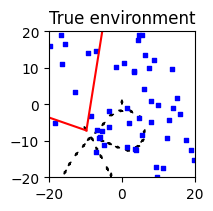

In [51]:
steps = 30
stepsize = 3
curviness = 0.5

x_true = [x_init]
obs = []

# generate input sequence
u = np.zeros((steps,3))
u[:,0] = stepsize
u[4:12,1] = curviness
u[18:26,1] = curviness

# Generate random trajectory instead
#u = np.append(stepsize*np.ones((steps,1),dtype='uint8'),
#              curviness*np.random.randn(steps,2),
#              axis=1)

# generate dynamic landmark trajectories
ldt = ld
for j in range(1,steps):
    # update dynamic landmarks
    F = np.array([[1,0,0,vm,0],
                  [0,1,0,0,vm],
                  [0,0,1,0,0],
                  [0,0,0,1,0],
                  [0,0,0,0,1]])
    for i in range(len(ld)):
        ld[i,:] = F.dot(ld[i,:].T).T
    ldt = np.dstack((ldt,ld))

# generate robot states and observations
for movement, t in zip(u,range(steps)):
    landmarks = np.append(ls,ldt[:,:3,t],axis=0)
    
    # process robot movement
    x_true.append(r1.move(movement))
    obs.append(r1.sense(landmarks))

plotMap(ls,ldt,x_true,r1,mapsize)

In [43]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plotMeasurement(mu, cov, obs, n):
    a = plt.subplot(132, aspect='equal')
        
    for z in obs:
        j = int(z[2])
        zx = mu[2*j+3]
        zy = mu[2*j+4]
        if j < n:
            plt.plot([mu[0][0], zx], [mu[1][0], zy], color=(0,0,1))
        else:
            plt.plot([mu[0][0], zx], [mu[1][0], zy], color=(0,1,0))
        
        landmark_cov = Ellipse(xy=[zx,zy], width=cov[2*j+3][2*j+3], height=cov[2*j+4][2*j+4], angle=0)
        landmark_cov.set_edgecolor((0,0,0))
        landmark_cov.set_fill(0)
        a.add_artist(landmark_cov)
        plt.pause(0.0001)
        
    plt.pause(0.01)

In [ ]:
def predict(mu, cov, u, Rt):
    n = len(mu)
    
    # Define motion model f(mu,u)
    [dtrans, drot1, drot2] = u
    motion = np.array([[dtrans*np.cos(mu[2][0]+drot1)],
              [dtrans*np.sin(mu[2][0]+drot1)],
              [drot1 + drot2]])
    F = np.append(np.eye(3),np.zeros((3,n-3)),axis=1)
    
    # Predict new state
    mu_bar = mu + (F.T).dot(motion)
    
    # Define motion model Jacobian
    J = np.array([[0,0,-dtrans*np.sin(mu[2][0]+drot1)],
               [0,0,dtrans*np.cos(mu[2][0]+drot1)],
               [0,0,0]])
    G = np.eye(n) + (F.T).dot(J).dot(F)
    
    # Predict new covariance
    cov_bar = G.dot(cov).dot(G.T) + (F.T).dot(Rt).dot(F)
    
    print('Predicted location\t x: {0:.2f} \t y: {1:.2f} \t theta: {2:.2f}'.format(mu_bar[0][0],mu_bar[1][0],mu_bar[2][0]))
    return mu_bar, cov_bar

In [ ]:
def update(mu,cov,obs,c_prob,Qt):
    N = len(mu)
    
    for [r, theta, j] in obs:
        j = int(j)
        # if landmark has not been observed before
        if cov[2*j+3][2*j+3] >= 1e6 and cov[2*j+4][2*j+4] >= 1e6:
            # define landmark estimate as current measurement
            mu[2*j+3][0] = mu[0][0] + r*np.cos(theta+mu[2][0])
            mu[2*j+4][0] = mu[1][0] + r*np.sin(theta+mu[2][0])

        
        # if landmark is static
        if c_prob[j] >= 0.5:
            # compute expected observation
            delta = np.array([mu[2*j+3][0] - mu[0][0], mu[2*j+4][0] - mu[1][0]])
            q = delta.T.dot(delta)
            sq = np.sqrt(q)
            z_theta = np.arctan2(delta[1],delta[0])
            z_hat = np.array([[sq], [z_theta-mu[2][0]]])
            
            # calculate Jacobian
            F = np.zeros((5,N))
            F[:3,:3] = np.eye(3)
            F[3,2*j+3] = 1
            F[4,2*j+4] = 1
            H_z = np.array([[-sq*delta[0], -sq*delta[1], 0, sq*delta[0], sq*delta[1]],
                            [delta[1], -delta[0], -q, -delta[1], delta[0]]], dtype='float')
            H = 1/q*H_z.dot(F)
    
            # calculate Kalman gain        
            K = cov.dot(H.T).dot(np.linalg.inv(H.dot(cov).dot(H.T)+Qt))
            
            # calculate difference between expected and real observation
            z_dif = np.array([[r],[theta]])-z_hat
            z_dif = (z_dif + np.pi) % (2*np.pi) - np.pi
            
            # update state vector and covariance matrix        
            mu = mu + K.dot(z_dif)
            cov = (np.eye(N)-K.dot(H)).dot(cov)
    
    print('Updated location\t x: {0:.2f} \t y: {1:.2f} \t theta: {2:.2f}'.format(mu[0][0],mu[1][0],mu[2][0]))
    return mu, cov, c_prob

In [58]:
def plotMeasurement(mu, cov, obs, n):
    a = plt.subplot(132, aspect='equal')
        
    for z in obs:
        j = int(z[2])
        zx = mu[2*j+3]
        zy = mu[2*j+4]
        if j < n:
            plt.plot([mu[0][0], zx], [mu[1][0], zy], color=(0,0,1))
        else:
            plt.plot([mu[0][0], zx], [mu[1][0], zy], color=(0,1,0))
        
        landmark_cov = Ellipse(xy=[zx,zy], width=cov[2*j+3][2*j+3], height=cov[2*j+4][2*j+4], angle=0)
        landmark_cov.set_edgecolor((0,0,0))
        landmark_cov.set_fill(0)
        a.add_artist(landmark_cov)
        plt.pause(0.0001)
        
    plt.pause(0.01)

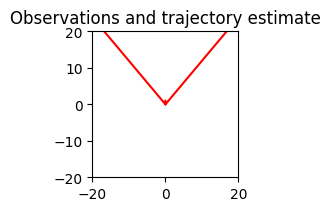

Predicted location	 x: 0.00 	 y: 3.00 	 theta: 1.57


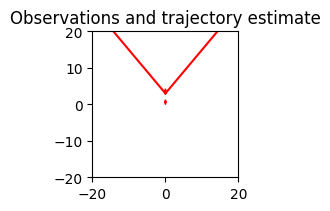

Measurements: 16
Updated location	 x: 0.00 	 y: 3.00 	 theta: 1.57


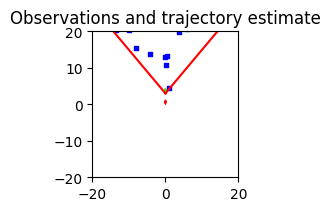

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

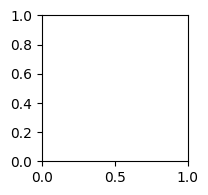

In [59]:
# Initialize state matrices
inf = 1e6

mu = np.append(np.array([x_init]).T,np.zeros((2*(n+k),1)),axis=0)
mu_new = mu

cov = inf*np.eye(2*(n+k)+3)
cov[:3,:3] = np.zeros((3,3))

c_prob = 0.5*np.ones((n+k,1))

plotEstimate(mu, cov, r1, mapsize)
plt.close('all')
for movement, measurement in zip(u, obs):
    mu_new, cov = predict(mu_new, cov, movement, Rt)
    mu = np.append(mu,mu_new,axis=1)
    plotEstimate(mu, cov, r1, mapsize)
    
    print('Measurements: {0:d}'.format(len(measurement)))
    mu_new, cov, c_prob_new = update(mu_new, cov, measurement, c_prob[:,-1].reshape(n+k,1), Qt)
    mu = np.append(mu,mu_new,axis=1)
    c_prob = np.append(c_prob, c_prob_new, axis=1)
    # plotEstimate(mu, cov, r1, mapsize)
    # plotMeasurement(mu_new, cov, measurement, n)
    
    plotError(mu,x_true[:len(mu[:,0::2])][:])
    print('----------')

In [78]:
import numpy as np
n_state = 3 # Number of state variables
robot_fov = 3 # robot field of view radius (m)

# Scattered Landmarks
# landmarks = [(12,12),
#              (4,4),
#              (4,12),
#              (15,10),
#              (9,1)]

# Rectangular pattern
landmarks = [(4,4)]

n_landmarks = len(landmarks)

# ---> Noise parameters
R = np.diag([0.002,0.002,0.0005]) # sigma_x, sigma_y, sigma_theta
Q = np.diag([0.003,0.005]) # sigma_r, sigma_phi

# ---> EKF Estimation Variables
mu = np.zeros((n_state+2*n_landmarks,1)) # State estimate (robot pose and landmark positions)
sigma = np.zeros((n_state+2*n_landmarks,n_state+2*n_landmarks)) # State uncertainty, covariance matrix

mu[:] = np.nan # Initialize state estimate with nan values
np.fill_diagonal(sigma,100) # Initialize state uncertainty with large variances, no correlations

# ---> Helpful matrix
Fx = np.block([[np.eye(3),np.zeros((n_state,2*n_landmarks))]]) # Used in both prediction and measurement updates

In [68]:
def prediction_update(mu,sigma,u,dt):
    '''
    This function performs the prediction step of the EKF. Using the linearized motion model, it
    updates both the state estimate mu and the state uncertainty sigma based on the model and known
    control inputs to the robot.
    Inputs:
     - mu: state estimate (robot pose and landmark positions)
     - sigma: state uncertainty (covariance matrix)
     - u: model input
     - dt: discretization time of continuous model
    Outpus:
     - mu: updated state estimate
     - sigma: updated state uncertainty
    '''
    x, y, yaw = mu[0],mu[1],mu[2]
    dx, dy, dyaw = u[0], u[1], u[2]
    # Update state estimate mu with model
    state_model_mat = np.zeros((n_state,1)) # Initialize state update matrix from model
    state_model_mat[0] = x + dx # Update in the robot x position
    state_model_mat[1] = y + dy # Update in the robot y position
    state_model_mat[2] = yaw + dyaw # Update for robot heading theta
    mu = mu + np.matmul(np.transpose(Fx),state_model_mat) # Update state estimate, simple use model with current state estimate
    # Update state uncertainty sigma
    sigma += np.transpose(Fx).dot(R).dot(Fx) # Combine model effects and stochastic noise
    return mu,sigma

In [67]:
def measurement_update(mu,sigma,zs):
    '''
    This function performs the measurement step of the EKF. Using the linearized observation model, it
    updates both the state estimate mu and the state uncertainty sigma based on range and bearing measurements
    that are made between robot and landmarks.
    Inputs:
     - mu: state estimate (robot pose and landmark positions)
     - sigma: state uncertainty (covariance matrix)
     - zs: list of 3-tuples, (dist,phi,lidx) from measurement function
    Outpus:
     - mu: updated state estimate
     - sigma: updated state uncertainty
    '''
    rx,ry,theta = mu[0,0],mu[1,0],mu[2,0] # robot 
    delta_zs = [np.zeros((2,1)) for lidx in range(n_landmarks)] # A list of how far an actual measurement is from the estimate measurement
    Ks = [np.zeros((mu.shape[0],2)) for lidx in range(n_landmarks)] # A list of matrices stored for use outside the measurement for loop
    Hs = [np.zeros((2,mu.shape[0])) for lidx in range(n_landmarks)] # A list of matrices stored for use outside the measurement for loop
    for z in zs:
        (dist,phi,lidx) = z
        mu_landmark = mu[n_state+lidx*2:n_state+lidx*2+2] # Get the estimated position of the landmark
        if np.isnan(mu_landmark[0]): # If the landmark hasn't been observed before, then initialize (lx,ly)
            mu_landmark[0] = rx + dist*np.cos(phi+theta) # lx, x position of landmark
            mu_landmark[1] = ry + dist*np.sin(phi+theta) # ly, y position of landmark
            mu[n_state+lidx*2:n_state+lidx*2+2] = mu_landmark # Save these values to the state estimate mu
        delta  = mu_landmark - np.array([[rx],[ry]]) # Helper variable
        q = np.linalg.norm(delta)**2 # Helper variable

        dist_est = np.sqrt(q) # Distance between robot estimate and landmark estimate, i.e., distance estimate
        phi_est = np.arctan2(delta[1,0],delta[0,0])-theta
        phi_est = np.arctan2(np.sin(phi_est),np.cos(phi_est)) # Estimated angled between robot heading and landmark
        z_est_arr = np.array([[dist_est],[phi_est]]) # Estimated observation, in numpy array
        z_act_arr = np.array([[dist],[phi]]) # Actual observation in numpy array
        delta_zs[lidx] = z_act_arr-z_est_arr # Difference between actual and estimated observation

        # Helper matrices in computing the measurement update
        Fxj = np.block([[Fx],[np.zeros((2,Fx.shape[1]))]])
        Fxj[n_state:n_state+2,n_state+2*lidx:n_state+2*lidx+2] = np.eye(2)
        H = np.array([[-delta[0,0]/np.sqrt(q), -delta[1,0]/np.sqrt(q), 0, delta[0,0]/np.sqrt(q), delta[1,0]/np.sqrt(q)],\
                      [delta[1,0]/q, -delta[0,0]/q, -1,-delta[1,0]/q, +delta[0,0]/q]])
        H = H.dot(Fxj)
        Hs[lidx] = H # Added to list of matrices
        Ks[lidx] = sigma.dot(np.transpose(H)).dot(np.linalg.inv(H.dot(sigma).dot(np.transpose(H)) + Q)) # Add to list of matrices
    # After storing appropriate matrices, perform measurement update of mu and sigma
    mu_offset = np.zeros(mu.shape) # Offset to be added to state estimate
    sigma_factor = np.eye(sigma.shape[0]) # Factor to multiply state uncertainty
    for lidx in range(n_landmarks):
        mu_offset += Ks[lidx].dot(delta_zs[lidx]) # Compute full mu offset
        sigma_factor -= Ks[lidx].dot(Hs[lidx]) # Compute full sigma factor
    mu = mu + mu_offset # Update state estimate
    sigma = sigma_factor.dot(sigma) # Update state uncertainty
    return mu,sigma

In [79]:
# Initialize robot and discretization time step
x_init = np.array([1,1,np.pi/2]) # px, py, theta
dt = 0.01

# Initialize robot state estimate and sigma
mu[0:3] = np.expand_dims(x_init,axis=1)
sigma[0:3,0:3] = 0.1*np.eye(3)
sigma[2,2] = 0 
u = np.array([0.5,0.,0.]) # Controls: u[0] = delta x, u[1] = delta y, u[3] = delta yaw
zs = np.array([1.0,2.0])
# EKF Slam Logic
# mu, sigma = prediction_update(mu,sigma,u,dt) # Perform EKF prediction update
# mu, sigma = measurement_update(mu,sigma,zs) # Perform EKF measurement update

In [91]:
Fx = np.block([[np.eye(3),np.zeros((n_state,2*n_landmarks))]]) # Used in both prediction and measurement updates
R = np.diag([0.002,0.002,0.0005]) # sigma_x, sigma_y, sigma_theta

sigma = np.zeros((n_state+2*n_landmarks,n_state+2*n_landmarks)) # State uncertainty, covariance matrix
np.fill_diagonal(sigma,100) # Initialize state uncertainty with large variances, no correlations
sigma[0:3,0:3] = 0.1*np.eye(3)
sigma[2,2] = 0 
sigma += np.transpose(Fx).dot(R).dot(Fx) # Combine model effects and stochastic noise
sigma

array([[1.02e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 1.02e-01, 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 5.00e-04, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 1.00e+02, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+02]])

In [164]:
Fx

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [92]:
np.block([[Fx],[np.zeros((2,Fx.shape[1]))]])

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [105]:
rx,ry,theta = mu[0,0],mu[1,0],mu[2,0] # robot 
delta_zs = [np.zeros((2,1)) for lidx in range(n_landmarks)] # A list of how far an actual measurement is from the estimate measurement
Ks = [np.zeros((mu.shape[0],2)) for lidx in range(n_landmarks)] # A list of matrices stored for use outside the measurement for loop
Hs = [np.zeros((2,mu.shape[0])) for lidx in range(n_landmarks)] # A list of matrices stored for use outside the measurement for loop
(dist,phi,lidx) = (1, 0.5, 0)
mu_landmark = mu[n_state+lidx*2:n_state+lidx*2+2] # Get the estimated position of the landmark
if np.isnan(mu_landmark[0]): # If the landmark hasn't been observed before, then initialize (lx,ly)
    mu_landmark[0] = rx + dist*np.cos(phi+theta) # lx, x position of landmark
    mu_landmark[1] = ry + dist*np.sin(phi+theta) # ly, y position of landmark
    mu[n_state+lidx*2:n_state+lidx*2+2] = mu_landmark # Save these values to the state estimate mu
delta  = mu_landmark - np.array([[rx],[ry]]) # Helper variable
q = np.linalg.norm(delta)**2 # Helper variable

dist_est = np.sqrt(q) # Distance between robot estimate and landmark estimate, i.e., distance estimate
phi_est = np.arctan2(delta[1,0],delta[0,0])-theta
phi_est = np.arctan2(np.sin(phi_est),np.cos(phi_est)) # Estimated angled between robot heading and landmark
z_est_arr = np.array([[dist_est],[phi_est]]) # Estimated observation, in numpy array
z_act_arr = np.array([[dist],[phi]]) # Actual observation in numpy array
delta_zs[lidx] = z_act_arr-z_est_arr # Difference between actual and estimated observation

# Helper matrices in computing the measurement update
Fxj = np.block([[Fx],[np.zeros((2,Fx.shape[1]))]])
Fxj[n_state:n_state+2,n_state+2*lidx:n_state+2*lidx+2] = np.eye(2)
H = np.array([[-delta[0,0]/np.sqrt(q), -delta[1,0]/np.sqrt(q), 0, delta[0,0]/np.sqrt(q), delta[1,0]/np.sqrt(q)],\
                [delta[1,0]/q, -delta[0,0]/q, -1,-delta[1,0]/q, +delta[0,0]/q]])
print("H: {}".format(H))
H = H.dot(Fxj)
print("Fxj: {}".format(Fxj))
print("H: {}".format(H))
Hs[lidx] = H # Added to list of matrices
Ks[lidx] = sigma.dot(np.transpose(H)).dot(np.linalg.inv(H.dot(sigma).dot(np.transpose(H)) + Q)) # Add to list of matrices
# After storing appropriate matrices, perform measurement update of mu and sigma
mu_offset = np.zeros(mu.shape) # Offset to be added to state estimate
sigma_factor = np.eye(sigma.shape[0]) # Factor to multiply state uncertainty
for lidx in range(n_landmarks):
    mu_offset += Ks[lidx].dot(delta_zs[lidx]) # Compute full mu offset
    sigma_factor -= Ks[lidx].dot(Hs[lidx]) # Compute full sigma factor
mu = mu + mu_offset # Update state estimate
sigma = sigma_factor.dot(sigma) # Update state uncertainty

H: [[ 0.47942554 -0.87758256  0.         -0.47942554  0.87758256]
 [ 0.87758256  0.47942554 -1.         -0.87758256 -0.47942554]]
Fxj: [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
H: [[ 0.47942554 -0.87758256  0.         -0.47942554  0.87758256]
 [ 0.87758256  0.47942554 -1.         -0.87758256 -0.47942554]]


In [101]:
H

array([[ 0.47942554, -0.87758256,  0.        , -0.47942554,  0.87758256],
       [ 0.87758256,  0.47942554, -1.        , -0.87758256, -0.47942554]])

# Simple EKF

You can recommend me a relevant association method relevant to this setup but the best i can think of in that sense of tight coupling is by simply estimating the euclidean distances between observations and reference points and do the association based on simple distance threshold.


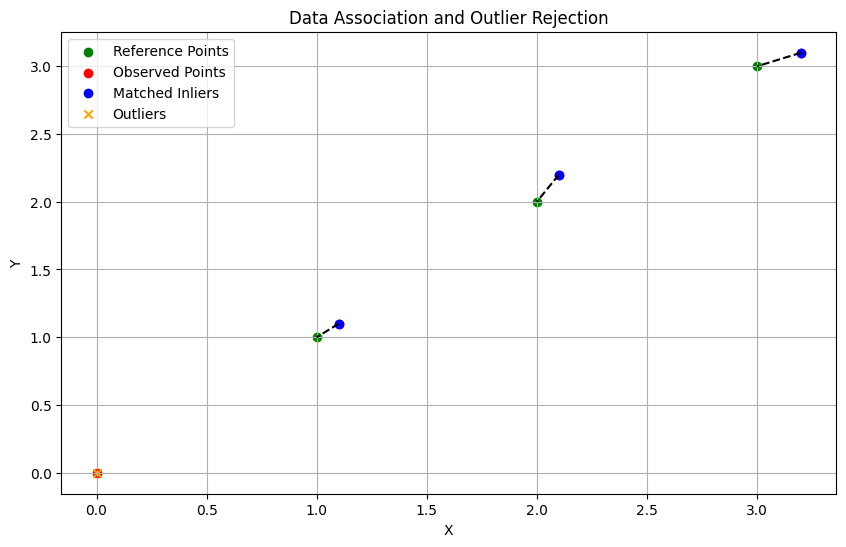

State Estimate: [0.16825397 0.5015873 ]
Covariance Matrix: [[0.52380952 0.        ]
 [0.         0.52380952]]


In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

class KalmanFilter:
    def __init__(self, Q, R, P, x):
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance
        self.P = P  # Estimate error covariance
        self.x = x  # State estimate

    def predict(self, delta_x):
        self.x = self.x + delta_x
        self.P = self.P + self.Q
        return self.x

    def update(self, z, H):
        y = z - H @ self.x
        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(self.P.shape[0]) - K @ H) @ self.P
        return self.x

# Data association using Nearest Neighbor
def match_points(observed_points, reference_points):
    tree = cKDTree(reference_points)
    distances, indices = tree.query(observed_points)
    return indices, distances

# RANSAC for outlier rejection
def ransac(observed_points, reference_points, threshold=1.0):
    indices, distances = match_points(observed_points, reference_points)
    inliers = distances < threshold
    return observed_points[inliers], reference_points[indices[inliers]], observed_points[~inliers]

# Example usage
Q = np.array([[0.1, 0], [0, 0.1]])
R = np.array([[1, 0], [0, 1]])
P = np.eye(2)
x = np.array([0, 1])

kf = KalmanFilter(Q, R, P, x)
delta_x = np.array([0.5, 0.2])

# Prediction step
kf.predict(delta_x)

# Example reference map points and observed points
reference_points = np.array([[1, 1], [2, 2], [3, 3]])
observed_points = np.array([[1.1, 1.1], [2.1, 2.2], [0, 0], [3.2, 3.1]])

# Match points and filter out outliers
observed_points_inliers, matched_reference_points, outliers = ransac(observed_points, reference_points)

# Measurement update step
# Construct the measurement matrix H and innovation vector z
H = np.eye(2)
if observed_points_inliers.size > 0:  # Avoid division by zero
    z = np.mean(matched_reference_points - observed_points_inliers, axis=0)
else:
    z = np.zeros(2)  # No inliers case

kf.update(z, H)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(reference_points[:, 0], reference_points[:, 1], c='green', label='Reference Points')
plt.scatter(observed_points[:, 0], observed_points[:, 1], c='red', label='Observed Points')
plt.scatter(observed_points_inliers[:, 0], observed_points_inliers[:, 1], c='blue', label='Matched Inliers')
plt.scatter(outliers[:, 0], outliers[:, 1], c='orange', label='Outliers', marker='x')

# Draw lines between matched points
for i in range(len(observed_points_inliers)):
    plt.plot([observed_points_inliers[i, 0], matched_reference_points[i, 0]],
             [observed_points_inliers[i, 1], matched_reference_points[i, 1]], 'k--')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data Association and Outlier Rejection')
plt.grid()
plt.show()

print("State Estimate:", kf.x)
print("Covariance Matrix:", kf.P)


controls: [array([0.10483886, 0.2029381 , 0.00874034]), array([0.08311606, 0.20571042, 0.01939734]), array([0.1028606 , 0.20424468, 0.01021092]), array([0.08934034, 0.19533131, 0.0227551 ]), array([ 0.10894598,  0.19775152, -0.00466778]), array([0.09085635, 0.18553259, 0.00641159]), array([ 0.086558  ,  0.19511292, -0.01371291]), array([0.10028891, 0.19023494, 0.00918134]), array([0.1172217 , 0.20731958, 0.01042309]), array([0.10252183, 0.19954623, 0.02432096]), array([0.11355851, 0.20654648, 0.01129851]), array([0.08563182, 0.20436983, 0.01319003]), array([0.11941416, 0.19722266, 0.01039367]), array([1.03816371e-01, 1.92949051e-01, 1.81490615e-04]), array([0.08936898, 0.20238947, 0.00505259]), array([0.10407805, 0.19238092, 0.00440354]), array([0.11462481, 0.19788096, 0.01271029]), array([0.08405499, 0.22143454, 0.00509364]), array([0.10026932, 0.21947096, 0.01041829]), array([0.10300567, 0.19074772, 0.01944567]), array([-0.04400768,  0.13833794, -0.00595868]), array([-0.04574749,  0.

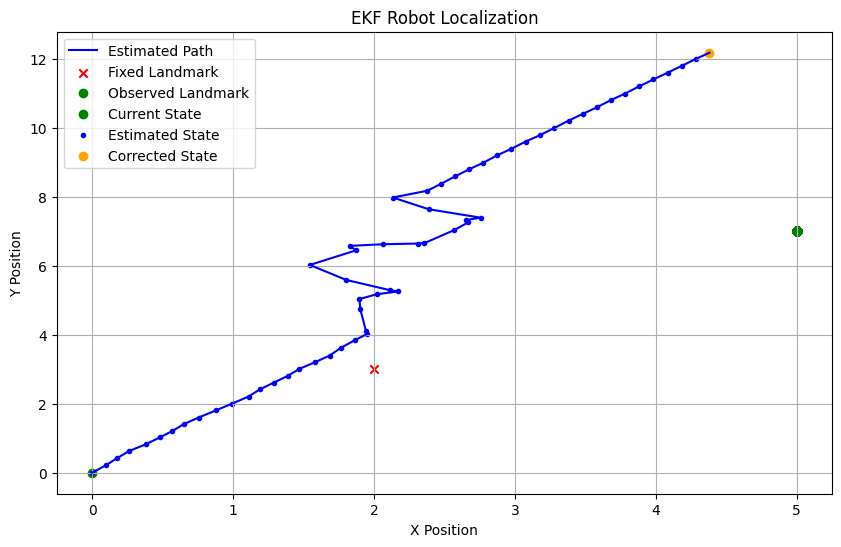

In [163]:
import numpy as np
import matplotlib.pyplot as plt

# Define the state transition function
def state_transition(state, control):
    # state = [x, y, theta]
    # control = [delta_x, delta_y, delta_theta]
    x, y, theta = state
    delta_x, delta_y, delta_theta = control
    x_new = x + delta_x
    y_new = y + delta_y
    theta_new = theta + delta_theta
    return np.array([x_new, y_new, theta_new])

# Define the observation model (distance between two landmarks)
def observation_model(state, fixed_landmark, observed_landmark):
    x, y, theta = state
    
    # Position of the fixed/reference landmark
    x1, y1 = fixed_landmark
    
    # Position of the observed landmark
    x2, y2 = observed_landmark
    
    # Positions of the landmarks relative to the robot
    dx1 = x1 - x
    dy1 = y1 - y
    dx2 = x2 - x
    dy2 = y2 - y
    
    # Rotate coordinates into the robot's frame of reference
    dx1_robot = dx1 * np.cos(theta) + dy1 * np.sin(theta)
    dy1_robot = -dx1 * np.sin(theta) + dy1 * np.cos(theta)
    dx2_robot = dx2 * np.cos(theta) + dy2 * np.sin(theta)
    dy2_robot = -dx2 * np.sin(theta) + dy2 * np.cos(theta)
    
    # Calculate the Euclidean distance between the landmarks in the robot's frame
    dist = np.sqrt((dx2_robot - dx1_robot)**2 + (dy2_robot - dy1_robot)**2)
    return np.array([dist])

# Jacobian of the observation model with respect to the state
def observation_jacobian(state, fixed_landmark, observed_landmark):
    x, y, theta = state
    
    # Position of the fixed/reference landmark
    x1, y1 = fixed_landmark
    
    # Position of the observed landmark
    x2, y2 = observed_landmark
    
    # Positions of the landmarks relative to the robot
    dx1 = x1 - x
    dy1 = y1 - y
    dx2 = x2 - x
    dy2 = y2 - y
    
    # Rotate coordinates into the robot's frame of reference
    dx1_robot = dx1 * np.cos(theta) + dy1 * np.sin(theta)
    dy1_robot = -dx1 * np.sin(theta) + dy1 * np.cos(theta)
    dx2_robot = dx2 * np.cos(theta) + dy2 * np.sin(theta)
    dy2_robot = -dx2 * np.sin(theta) + dy2 * np.cos(theta)
    
    # Differences between landmark positions in the robot's frame
    delta_x = dx2_robot - dx1_robot
    delta_y = dy2_robot - dy1_robot
    dist = np.sqrt(delta_x**2 + delta_y**2)
    
    # Partial derivatives of the distance with respect to state variables
    H = np.zeros((1, 3))
    H[0, 0] = (delta_x * (-(np.cos(theta)) - dx1 * np.sin(theta) + np.cos(theta) - dx2 * np.sin(theta)) + delta_y * (-(np.sin(theta)) + dy1 * np.cos(theta) + np.sin(theta) - dy2 * np.cos(theta))) / dist
    H[0, 1] = (delta_x * (-(np.sin(theta)) + dx1 * np.cos(theta) - np.sin(theta) + dx2 * np.cos(theta)) + delta_y * (-(np.cos(theta)) - dy1 * np.sin(theta) + np.cos(theta) - dy2 * np.sin(theta))) / dist
    H[0, 2] = ((-dx1 * np.cos(theta) + dy1 * np.sin(theta) + dx2 * np.cos(theta) - dy2 * np.sin(theta)) * delta_x + (-dx1 * np.sin(theta) - dy1 * np.cos(theta) + dx2 * np.sin(theta) + dy2 * np.cos(theta)) * delta_y) / dist
    return H

# EKF update step
def ekf_update(state, P, control, measurement, R, fixed_landmark, observed_landmark):
    # Predict
    state_pred = state_transition(state, control)
    G = np.eye(3)  # Jacobian of the state transition is identity with respect to state
    P_pred = G @ P @ G.T + Q

    # Update
    z_pred = observation_model(state_pred, fixed_landmark, observed_landmark)
    H = observation_jacobian(state_pred, fixed_landmark, observed_landmark)
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    state_upd = state_pred + K @ (measurement - z_pred)
    P_upd = (np.eye(len(state)) - K @ H) @ P_pred

    return state_upd, P_upd

# Initial state
state = np.array([0, 0, 0])  # [x, y, theta]
P = np.eye(3) * 0.1  # Initial covariance

# Process noise covariance
Q = np.eye(3) * 0.01

# Measurement noise covariance
R = np.array([[0.000001]])

# Landmarks positions
fixed_landmark = np.array([2, 3])  # Fixed/reference landmark
observed_landmark_initial = np.array([5, 7])  # Initial position of the observed landmark

# Define the standard deviation of noise for each control input
noise_std = [0.01, 0.2, 0.001]  # Adjust these values as needed

# Generate control inputs with noise
controls = [np.array([0.1, 0.2, 0.01]) + np.random.normal(0, std, size=3) for std in noise_std for _ in range(20)]

print("controls: {}".format(controls))

# Measurements (distance between landmarks)
measurements = []

# Lists to store the estimated states for plotting
estimated_states = [state]

observed_landmarks = [observed_landmark_initial]

# Run the EKF through all control inputs and measurements
for i, control in enumerate(controls):
    noise = np.random.normal(0, 1.0, size=2)
    # Update observed landmark's position (for demonstration purposes)
    observed_landmark = observed_landmarks[-1]
    observed_landmarks.append(observed_landmark)
    # Generate measurement based on the new observed landmark's position
    measurement = observation_model(state_transition(state, control), fixed_landmark, observed_landmark) + np.random.normal(0, 0.1)
    measurements.append(measurement)
    
    # Perform EKF update
    state, P = ekf_update(state, P, control, measurement, R, fixed_landmark, observed_landmark)
    estimated_states.append(state)

# Convert estimated_states to numpy array
estimated_states = np.array(estimated_states)
observed_landmarks = np.array(observed_landmarks)
# Plotting the results
plt.figure(figsize=(10, 6))

# Plotting the estimated path of the robot
plt.plot(estimated_states[:, 0], estimated_states[:, 1], label='Estimated Path', color='blue')

# Plotting the fixed/reference landmark
plt.scatter(fixed_landmark[0], fixed_landmark[1], c='red', marker='x', label='Fixed Landmark')

# Plotting the changing observed landmark in each iteration
for i in range(len(controls)):
    plt.scatter(observed_landmarks[:, 0], observed_landmarks[:, 1], c='green', marker='o', label='Observed Landmark' if i == 0 else None)

# Plotting the current, estimated, and corrected states of the robot
plt.scatter(estimated_states[0, 0], estimated_states[0, 1], c='green', marker='o', label='Current State')
plt.scatter(estimated_states[:, 0], estimated_states[:, 1], c='blue', marker='.', label='Estimated State')
plt.scatter(estimated_states[-1, 0], estimated_states[-1, 1], c='orange', marker='o', label='Corrected State')

plt.title('EKF Robot Localization')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid()
plt.show()

controls: [array([0.10466531, 0.18963361, 0.00627986]), array([0.10001522, 0.20927526, 0.00629049]), array([0.1183679 , 0.19999111, 0.01000631]), array([0.11394084, 0.20502795, 0.02085556]), array([0.10746816, 0.18879348, 0.01088787]), array([ 0.09333624,  0.18316207, -0.00277188]), array([0.09585335, 0.22026549, 0.0076116 ]), array([0.08880517, 0.19792794, 0.00753497]), array([ 9.89708649e-02,  1.92676559e-01, -1.56280215e-04]), array([0.1148512 , 0.20919826, 0.02367351]), array([0.12614998, 0.19087364, 0.02381137]), array([ 0.10314803,  0.20282723, -0.00135277]), array([0.10840323, 0.19878569, 0.0122868 ]), array([0.11543745, 0.19007194, 0.00293536]), array([0.09785532, 0.18246292, 0.01455775]), array([0.09292417, 0.1816525 , 0.00289085]), array([0.11088248, 0.21750912, 0.01060798]), array([0.09950048, 0.21454275, 0.00671185]), array([0.11846572, 0.20932458, 0.02026161]), array([0.08193624, 0.21490223, 0.02551034]), array([-0.04906138,  0.12126101, -0.03927072]), array([0.32159735, 0

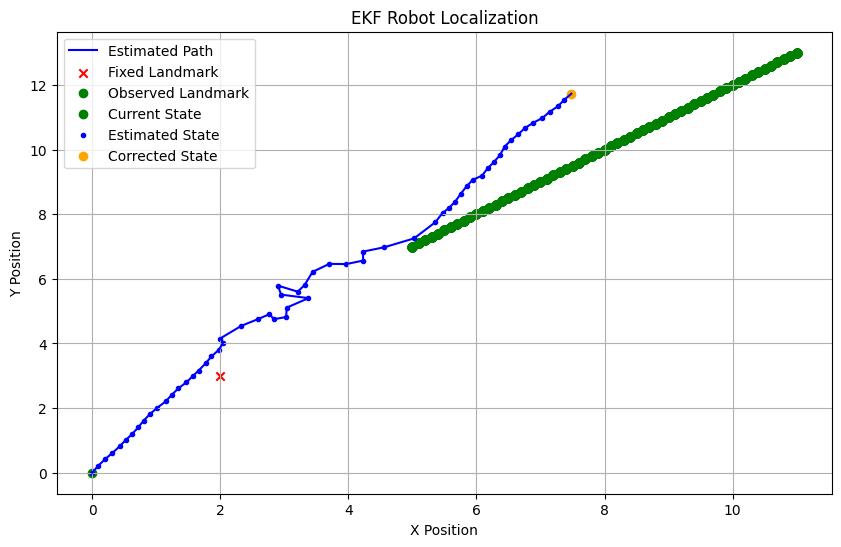

[array([5, 7]),
 array([4.89012846, 7.07028911]),
 array([4.98979278, 6.93622941]),
 array([4.89549206, 7.097106  ]),
 array([4.92277534, 6.93127585]),
 array([5.1377039 , 7.00144005]),
 array([4.97134827, 7.11735077]),
 array([5.01913752, 7.01312327]),
 array([4.89839427, 7.14054798]),
 array([5.0789477 , 6.94322347]),
 array([5.00955014, 6.88948822]),
 array([5.1210726 , 6.93988838]),
 array([4.74283652, 6.94287063]),
 array([5.06068587, 7.07410646]),
 array([4.90692807, 7.05279045]),
 array([4.91491998, 7.09373226]),
 array([5.09551662, 6.9743977 ]),
 array([5.00892419, 6.99240919]),
 array([5.03046308, 6.92266194]),
 array([4.98090989, 6.99991285]),
 array([4.89524158, 7.00351723])]

In [17]:
#| hide
import nbdev; nbdev.nbdev_export()